In [14]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import shap

import scipy
from scipy.stats import entropy
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

import sklearn
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

# In this project, always use fstring for formatting, which requires Python 3.6+

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Generate a binary classification dataset with correlated features and a target
X, y = make_classification(n_samples=10000, n_features=10, n_informative=3, n_redundant=4, n_repeated=3, n_classes=2, random_state=0, shuffle=False)
print(X.shape, y.shape)

(10000, 10) (10000,)


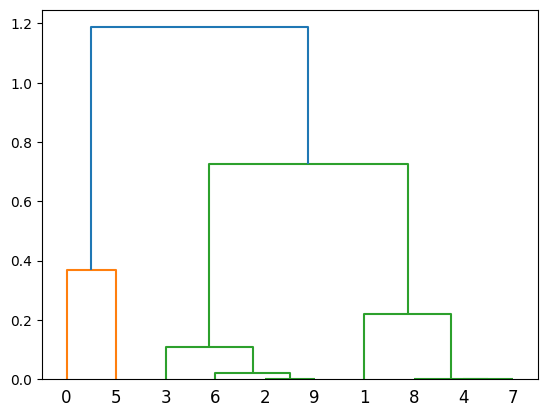

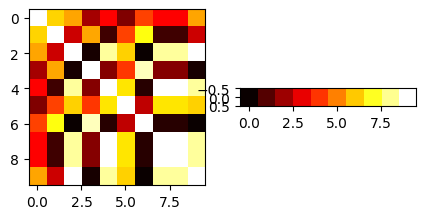

In [16]:
# calculate correlation matrix
corr = spearmanr(X).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(dist_linkage, labels=range(X.shape[1]), orientation='top')
dendro_idx = np.arange(0, len(dendro['ivl']))

# plot dendro and dendro_idx in one figure. dendro in left; dendro_idx in right
fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].imshow(corr, cmap='hot')
ax[1].imshow(dendro_idx.reshape(1, -1), cmap='hot')
plt.show()

# observation
Informative features: 0, 1, 2
Redundant features: 3, 4, 5, 6
Repeated features: 7, 8, 9

By setting the threshold to 0.5, the features are clustered n 3 clusters. Each cluster contains an informative feature and some other features.

In [17]:
# cluster the features based on the dendrogram
cluster_threshold = 0.5
cluster_ids = hierarchy.fcluster(dist_linkage, cluster_threshold, criterion='distance')
cluster_ids_to_feature_ids = {cluster_id: list(np.where(cluster_ids == cluster_id)[0]) for cluster_id in np.unique(cluster_ids)}
print(cluster_ids_to_feature_ids)
print(cluster_ids)

{1: [0, 5], 2: [2, 3, 6, 9], 3: [1, 4, 7, 8]}
[1 3 2 2 3 1 2 3 3 2]


In [18]:
# train a xgboost model
model = xgb.XGBClassifier(n_estimators=10, random_state=0)
model.fit(X, y)
print("Done training")
scores = permutation_importance(model, X, y, n_repeats=5, random_state=0)
print(scores.importances_mean)
print(model.feature_importances_)

Done training
[0.06268 0.01796 0.0024  0.003   0.24332 0.33008 0.00224 0.      0.
 0.     ]
[0.07803551 0.05109254 0.01938937 0.01190284 0.5326214  0.26691148
 0.04004691 0.         0.         0.        ]


In [19]:
feature_importance = {}
for cluster_id, feature_ids in cluster_ids_to_feature_ids.items():
    scores = []
    for i, fid in enumerate(feature_ids):
        feature = X[:, fid].reshape(-1, 1)
        excluding_features = feature_ids[i:]  # excluding all features in cluster after the current feature (including itself)
        X_residual = np.delete(X, excluding_features, axis=1)
        X_residual_self = np.concatenate((X_residual, feature), axis=1)
        # print(X_residual_self.shape)
        model = xgb.XGBClassifier(n_estimators=10, random_state=0)
        model.fit(X_residual_self, y)
        score_raw = permutation_importance(model, X_residual_self, y, n_repeats=5, random_state=0)
        # print(score_raw.importances_mean)
        # print(model.feature_importances_)
        score = score_raw.importances_mean[-1]       # first column is the score of this feature
        scores.append(score)
        print(f"Cluster {cluster_id}, feature {fid}, score {score:.4f}")
    feature_importance[cluster_id] = scores

for cluster_id, scores in feature_importance.items():
    # each score is printed with 4 decimal places
    print(f"Cluster {cluster_id}: {[f'{score:.4f}' for score in scores]}")

Cluster 1, feature 0, score 0.3058
Cluster 1, feature 5, score 0.3265
Cluster 2, feature 2, score 0.0245
Cluster 2, feature 3, score 0.0023
Cluster 2, feature 6, score 0.0022
Cluster 2, feature 9, score 0.0000
Cluster 3, feature 1, score 0.2234
Cluster 3, feature 4, score 0.2433
Cluster 3, feature 7, score 0.0000
Cluster 3, feature 8, score 0.0000
Cluster 1: ['0.3058', '0.3265']
Cluster 2: ['0.0245', '0.0023', '0.0022', '0.0000']
Cluster 3: ['0.2234', '0.2433', '0.0000', '0.0000']


# observation
In each cluster, the first feature is the most important feature. The second feature is the second most important feature. This is because of the correlation between features.

In [20]:
 # randomly split the features into two parties according to dirichlet distribution

n_trials = 1000
n_parties = 2
dir_beta = 1

def random_split_feature_ids(dir_beta, cluster_ids_to_feature_ids, n_parties):
    # shuffle the features in each cluster
    cid_to_fid_perm = {}
    for cluster_id, feature_ids in cluster_ids_to_feature_ids.items():
        cid_to_fid_perm[cluster_id] = list(np.random.permutation(feature_ids))

    ratios = np.random.dirichlet(np.ones(n_parties) * dir_beta)
    n_features = np.zeros(n_parties, dtype=int)
    fid_to_party_id = -np.ones(X.shape[1], dtype=int)
    # assign the features to each party according to the ratio
    while np.sum(n_features) < X.shape[1]:
        party_ids = np.random.choice(n_parties, size=len(cid_to_fid_perm), p=ratios) # randomly assign each cluster a party ID
        # select and remove the last feature in each cluster
        feature_ids = [cid_to_fid_perm[cluster_id].pop() for cluster_id in cid_to_fid_perm]
        fid_to_party_id[feature_ids] = party_ids

        # update the number of features in each party
        for party_id in party_ids:
            n_features[party_id] += 1
        # update ratios
        ratios = np.random.dirichlet(np.ones(n_parties) * (dir_beta + n_features))
        # remove empty clusters
        cid_to_fid_perm = {cluster_id: feature_ids for cluster_id, feature_ids in cid_to_fid_perm.items() if len(feature_ids) > 0}
        # print(ratios)
        # print(party_ids)
        # print(feature_ids)
        # print(n_features)
    return fid_to_party_id

fid_to_pid_all = np.zeros((n_trials, X.shape[1]), dtype=int)
pid_cnt = np.zeros((n_trials, n_parties), dtype=int)
for i in range(n_trials):
    fid_to_pid_all[i] = random_split_feature_ids(dir_beta, cluster_ids_to_feature_ids, n_parties)
    for pid in fid_to_pid_all[i]:
        pid_cnt[i, pid] += 1
print(np.mean(pid_cnt, axis=0))
print(np.std(pid_cnt, axis=0))
print(np.mean(np.std(pid_cnt, axis=1)))
print(fid_to_pid_all)



[5.039 4.961]
[3.12721585 3.12721585]
2.679
[[0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 0 1 1]]


In [21]:
# random split features into two parties with new method (alpha, beta)
def split_feature_ids(cluster_id_to_feature_ids, n_parties, alpha, beta):
    feature_id_to_cluster_id = {}
    for cluster_id, feature_ids in cluster_ids_to_feature_ids.items():
        for feature_id in feature_ids:
            feature_id_to_cluster_id[feature_id] = cluster_id

    # initialize alpha matrix as the value of alpha (size n_parties x n_features)
    alpha_matrix = np.ones((n_parties, len(feature_id_to_cluster_id))) * alpha

    feature_id_to_party_id = -np.ones(X.shape[1], dtype=int)
    for feature_id, cluster_id in feature_id_to_cluster_id.items():
        # obtain alpha parameters for the current feature
        alpha_vector = alpha_matrix[:, feature_id]
        ratios = np.random.dirichlet(alpha_vector)
        party_id = np.random.choice(n_parties, p=ratios)
        feature_id_to_party_id[feature_id] = party_id

        # update alpha matrix - multiply the alpha of the other features in the same cluster by beta
        for feature_id_2 in cluster_id_to_feature_ids[cluster_id]:
            if feature_id_2 != feature_id:
                alpha_matrix[party_id, feature_id_2] *= beta

    return feature_id_to_party_id


In [22]:

n_trials = 1000
n_parties = 2
alpha = 1
beta = 2
fid_to_pid_all = np.zeros((n_trials, X.shape[1]), dtype=int)
pid_cnt = np.zeros((n_trials, n_parties), dtype=int)
for i in range(n_trials):
    fid_to_pid_all[i] = split_feature_ids(cluster_ids_to_feature_ids, n_parties, alpha, beta)
    for pid in fid_to_pid_all[i]:
        pid_cnt[i, pid] += 1
print(np.mean(pid_cnt, axis=0))
print(np.std(pid_cnt, axis=0))
print(np.mean(np.std(pid_cnt, axis=1)))
print(fid_to_pid_all)



[5.017 4.983]
[2.34109184 2.34109184]
1.891
[[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [1 1 0 ... 1 0 0]
 [0 1 1 ... 1 1 1]
 [1 1 1 ... 0 1 0]]


In [23]:
# get standardized data
X, y = shap.datasets.california(n_points=1000)
X_sample = shap.sample(X, 100)

model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

# explain the model's predictions using SHAP
explainer = shap.explainers.Permutation(model.predict, X_sample)
shap_values = explainer(X_sample)

shap.plots.waterfall(shap_values[0])

URLError: <urlopen error Remote end closed connection without response>

In [24]:
shap.summary_plot(shap_values, X_sample)

NameError: name 'shap_values' is not defined

In [ ]:
from src.preprocess.FeatureSplitter import ImportanceSplitter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

X, y = make_classification(n_samples=1000, n_features=10, n_informative=10, n_redundant=0, n_repeated=0,
                               n_classes=2, random_state=0, shuffle=True)
X = MinMaxScaler().fit_transform(X)
model = LogisticRegression()
model.fit(X, y)

for i, w in enumerate(range(0.5, 4, 0.5)):
    splitter = ImportanceSplitter(num_parties=n_parties, weights=w, seed=i)
    n_features_std_summary = []
    for j in round(100):
        Xs = splitter.split(X)
        n_features = [X.shape[1] for X in Xs]
        n_features_std = np.std(n_features)
        n_features_std_summary.append(n_features_std)
    print(np.mean(n_features_std_summary))




In [32]:

from src.preprocess.FeatureSplitter import ImportanceSplitter
import numpy as np

X = np.zeros([2, 6000])

splitter = ImportanceSplitter(num_parties=4, weights=0.1)
Xs = splitter.split(X)
print(f"Size of Xs: {[X.shape for X in Xs]}")

Size of Xs: [(2, 1), (2, 5), (2, 801), (2, 5189)]


In [39]:
# auto reload modules that changed
%load_ext autoreload
%autoreload 2

In [11]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))
from src.dataset.VFLDataset import VFLAlignedDataset

dataset = 'realsim'
for ratio in [0.1, 1.0, 10, 100]:
    num_parties = 4
    data = VFLAlignedDataset.from_pickle(f"data/syn/{dataset}", dataset, num_parties, splitter='imp', weight=ratio, seed=2)

    # get the size of each local party
    n_features = [d.X.shape[1] for d in data.local_datasets]
    print(f"Size of Xs ratio {ratio}: {n_features}")

Size of Xs ratio 0.1: [1779, 17946, 1227, 2]
Size of Xs ratio 1.0: [6124, 304, 8461, 6065]
Size of Xs ratio 10: [5869, 6473, 3561, 5051]
Size of Xs ratio 100: [5466, 5575, 4703, 5210]
